In [1]:
import pandas as pd
import numpy as np
import validators

from datetime import datetime
from matplotlib import pyplot as plt
from unidecode import unidecode

from scripts.evaluation import get_green_rating
from scripts.cleaning import is_aberration

plt.style.use("fivethirtyeight")


In [2]:
%%time
# Data Loading

tabsv = "data/off_dataset.tsv"

df_off = pd.read_csv(tabsv, sep="\t", dtype="unicode", low_memory=False)


CPU times: total: 14.2 s
Wall time: 14.3 s


In [3]:
print(df_off.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Columns: 162 entries, code to water-hardness_100g
dtypes: object(162)
memory usage: 396.5+ MB
None


<h1>Nettoyage du dataset</h1>

<h4>Infos du TSV</h4>
- 320772 lignes (produits)
- 162 variables (colonnes)

<h2>Présentation/Proposition d'application</h2>

<h2>Sélection des variables et nettoyage des données</h2>

-> Suppression des duplicatas, suppression des aberrations et incoherences

1 - Actions sur le code


2 - Actions sur les timestamps

3 - Nettoyage des données manquantes

<h3>Variables techniques : </h3>

- Un produit est défini par :
    - Son code (on ne gardera que son code EAN13, en ignorant ceux commençant par 200, préfixe utilisé par OFF par défaut)
    - Son nom (product_name)
    - Sa/ses catégories (main_category, categories)
    - Son URL
    - La data de sa derniere modification
Peu importe le choix d'application, ces variables sont essentielles.

<h3>Variables métier :</h3>

1 - Représentation des variables et sélection

2 - Liste des variables inutiles

3 - Filtrage par pays

4 - Cas des variables pour 100g

<h3>Creation d'une variable de représentation écologique et bio</h3>

<h3>Export du DataFrame</h3>
<hr>

Presentation/Proposition d'application

Création d'une application desktop/mobile permettant de :

- 1 : Scanner un produit via son EAN13
- 2 : Recevoir des suggestions de produits plus sains
- 2.optionnel : Intégrer l'importance écologique/bio dans les suggestions
- 2.optionnel : Intégrer la localisation dans les suggestions
- 3 : Possibilité de sauvegarder, filtrer par magasin
- 3.optionnel : Possibilité de renseigner le lieu où se trouve le produit

<hr>
<hr>

<h3>1 : Actions sur le code :</h3>

- Suppression des données manquantes
- Suppression des doublons
- Suppression des EANs 13 invalides (< 13 chiffres)
- Suppression des EANs 13 attribués par Open Food Facts (200XXXXXXXXXX)

In [4]:
# Set of filters necessary for any study

def ean_actions(df: pd.DataFrame) -> pd.DataFrame:
    df.dropna(subset="code", inplace=True)
    df.drop_duplicates(subset="code", keep="first", inplace=True)
    df = df[~df["code"].str.startswith(('200'))]
    df = df[df["code"].map(len) == 13]
    
    return df


In [5]:
df_off = ean_actions(df=df_off)


Note : Les codes commenceant par n*0+code ne sont pas supprimés

<h2>2 : Actions sur la date de modification la plus récente :</h2>

Suppression si :
- Le timestamp n'est pas un nombre
- Le timestamp est inferieur a 0
- Le timestamp est plus récent que la date actuelle
<a id='another_cell'></a>


In [6]:
# Removing non numeric values for last_modified_t
# Removing aberrations in timestamps, modifying timestamp type to float

df_off = df_off[pd.to_numeric(df_off['last_modified_t'], errors='coerce').notnull()]
now_t = datetime.timestamp(datetime.now())

df_off["last_modified_t"] = df_off["last_modified_t"].astype(float)

df_off = df_off[(df_off["last_modified_t"] < now_t) & (df_off["last_modified_t"] > 0)]


<h2>3 : Nettoyage des données manquantes</h2>

- URL, nom du produit, Nutriscore : Nécessaire - suppression de la ligne
- Au moins une catégorie, sinon : suppression de la ligne

<i>Il semblerait que les variables "pnns_group_1" et "pnns_group_2" correspondent également à des catégories</i>

In [7]:
%%time

# Applying filters
# Category needs at least 1

condition_list = ["url", "product_name", "nutrition_grade_fr"]
category_list =  ["main_category", "categories"]

df_off.dropna(subset=condition_list, inplace=True)
df_off = df_off.dropna(subset=category_list, thresh=1).reset_index(drop=True)


CPU times: total: 828 ms
Wall time: 852 ms


<h1>Variables métier</h1>

<h2>1 : Représentation du remplissage des variables et sélection</h2>

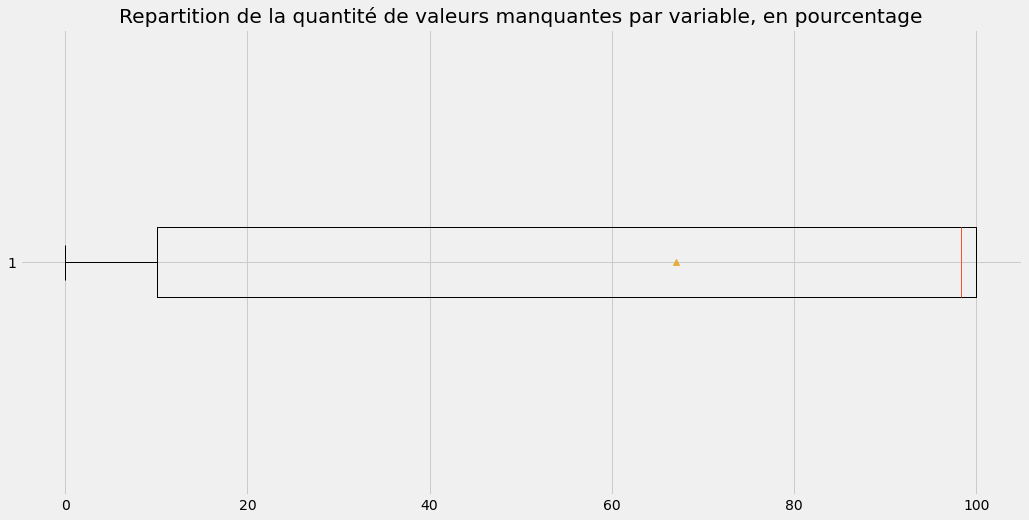

In [8]:
#NA Amount % = [NA amount / len(df)] / 100

data_len = len(df_off)
above_fifty = []
above_seventy_five = []
under_fifty = []
nan_per_col = {}

for column in df_off.columns:
    nan_percent = df_off[column].isnull().sum() / data_len * 100
    if nan_percent > 75:
        above_seventy_five.append(column)
    elif nan_percent > 50:
        above_fifty.append(column)
    else:
        under_fifty.append(column)
    nan_per_col[column] = nan_percent

box = plt.figure(figsize=(16, 8))

plt.title("Repartition de la quantité de valeurs manquantes par variable, en pourcentage")

plt.boxplot(nan_per_col.values(), vert=False, showfliers=True, showmeans=True)

plt.show()


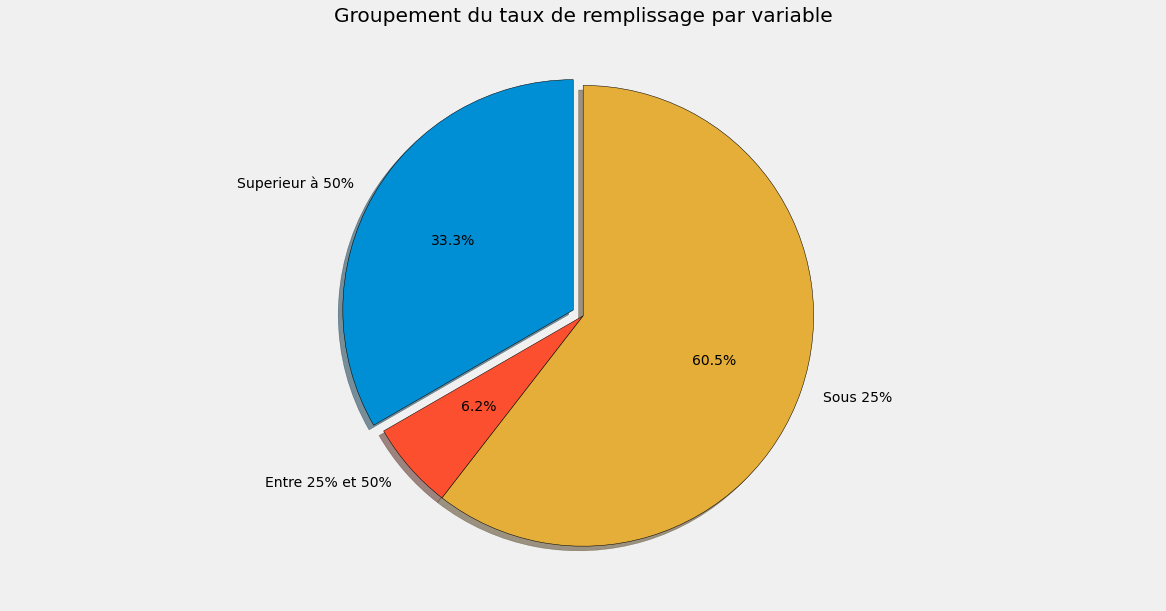

In [9]:

slices = [len(under_fifty), len(above_fifty), len(above_seventy_five)]
labels = ["Superieur à 50%", "Entre 25% et 50%", "Sous 25%"]

explode = [0.05, 0, 0]

fig = plt.figure(figsize=(16,8))

ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
ax.pie(slices, labels=labels, explode=explode, shadow=True,
        startangle=90, autopct='%1.1f%%',
        wedgeprops={'edgecolor': 'black'})


plt.title("Groupement du taux de remplissage par variable")

plt.show()


### Graphe de représentation du taux de remplissage des variables du dataset :

Seulement 33.3% des colonnes présentent un taux de remplissage au dessus de 50%, après avoir appliqué les filtres des étapes précédentes.
Il est possible que la plupart des valeurs manquantes viennent des valeurs pour 100g.

<i>Verification en ajustant les parametres pour exclure les valeurs pour 100g.</i>

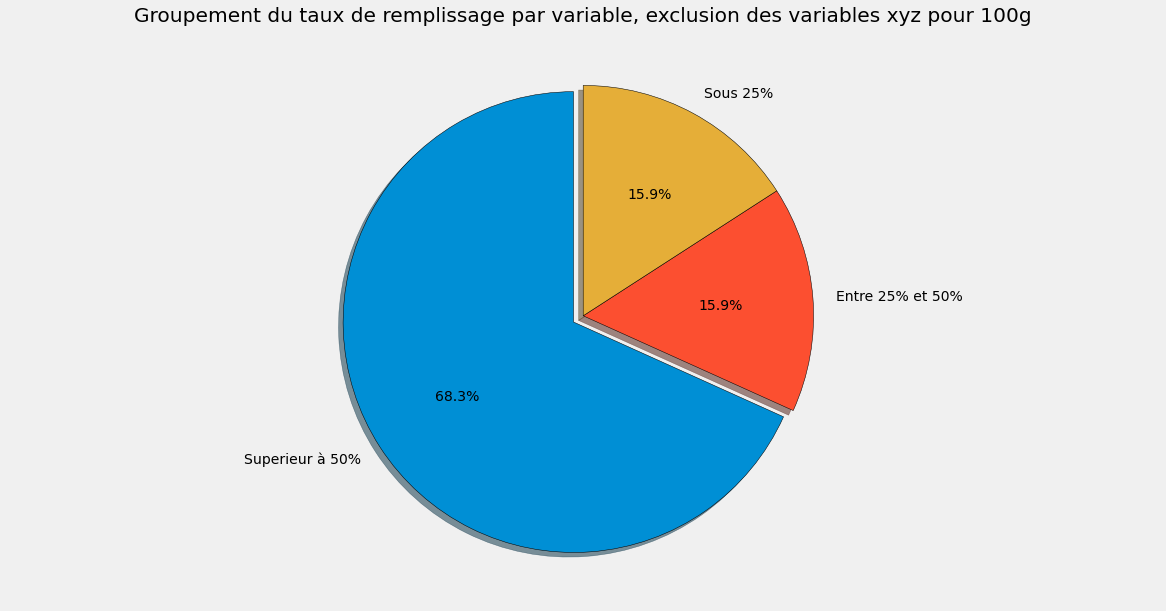

In [10]:

above_fifty = []
above_seventy_five = []
under_fifty = []
nan_per_col = {}

for column in df_off.columns:

    if column.endswith("100g"): #  Skipping names ending with 100g
        continue

    nan_percent = df_off[column].isnull().sum() / data_len * 100

    if nan_percent > 75:
        above_seventy_five.append(column)

    elif nan_percent > 50:
        above_fifty.append(column)

    else:
        under_fifty.append(column)
    nan_per_col[column] = nan_percent


slices = [len(under_fifty), len(above_fifty), len(above_seventy_five)]
labels = ["Superieur à 50%", "Entre 25% et 50%", "Sous 25%"]

explode = [0.05, 0, 0]

fig = plt.figure(figsize=(16,8))

ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
ax.pie(slices, labels=labels, explode=explode, shadow=True,
        startangle=90, autopct='%1.1f%%',
        wedgeprops={'edgecolor': 'black'})


plt.title("Groupement du taux de remplissage par variable, exclusion des variables xyz pour 100g")

plt.show()


### Représentation du taux de remplissage des variables, en excluant les variables xyz_pour_100g

Les valeurs pour 100g affectent effectivement négativement le taux de variables manquantes. Une de ces raisons est sans doute le fait que certains composants ne figurent simplement pas dans le produit.

Une sélection plus en détail des composants principaux pour refléter les besoins de l'application sera faite.
Un premier filtrage des aberration va etre fait pour determiner si certains produits ont des valeurs aberrantes dans ces categories, si c'est le cas, le produit sera supprimé du dataset, les autres données sont plus suceptibles d'etre elles aussi fausses.

Les variables avec un taux de remplissage inferieur à 50% (excluant les valeurs pour 100g) seront abandonnées, à l'exception de possibles variables necessaires au fonctionnement de l'application.

<h2>2 : Suppression de variables non nécessaires :</h2>

In [11]:
# Var selection

useless_vars = [
    "states_tags", "ingredients_text", "states_tags", "creator",
    "states_fr", "main_category", "serving_size", "created_datetime",
    "additives", "additives_fr", "main_category", "ingredients_text",
    "last_modified_datetime", "quantity", "countries", "countries_fr",
    "created_t", "additives", "additives_tags", "labels", "labels_tags",
    "categories", "categories_tags", "states", "countries_tags", "additives_n"
]
maybe_useless = ["packaging", "packaging_tags", "image_small_url", "generic_name", "brands_tags", "purchase_places"]

useful_above_fifty = ["allergens"]


<h4>Variables techniques necessaires :</h4>

- code
- url
- last_modified_t
- product_name
- categories_fr


<h4>Variables metier interessantes :</h4>

- pnns_groups_1 & 2
- categories + categories_tags (?) (choix en fonction du taux de remplissage s'il diffère)
- main_category_fr
- nutrition_grade_fr
- image_url ?
- brands
- stores
- countries_fr
- ingredients_from_palm_oil_n
- ingredients_that_may_be_from_palm_oil_n
- labels (?) -> Sera choisi en fonction du taux de remplissage (labels, labels_tags, labels_fr)
- allergens (variable peu remplie mais importante à l'application : le manque de donnée peut signifier l'absence d'allergène ou le manque d'information)



<h2>3 : Filtrage par pays :</h2>
L'application vise un public résident en france, seuls les produits pouvant être trouvés en France seront gardés

In [12]:
df_off = df_off[df_off["countries_tags"] == "en:france"]

In [13]:
remaining = list(set(under_fifty) - set(useless_vars) - set(maybe_useless))
remaining = remaining + useful_above_fifty
remaining

print("\n", len(remaining))



 16


<h2>4 : Cas des valeurs pour 100g</h2>
Visualisation des variables suivant leur remplissage.

In [14]:
hundred_g_list = [col for col in df_off.columns if col.endswith("100g")]
print(len(hundred_g_list))


99


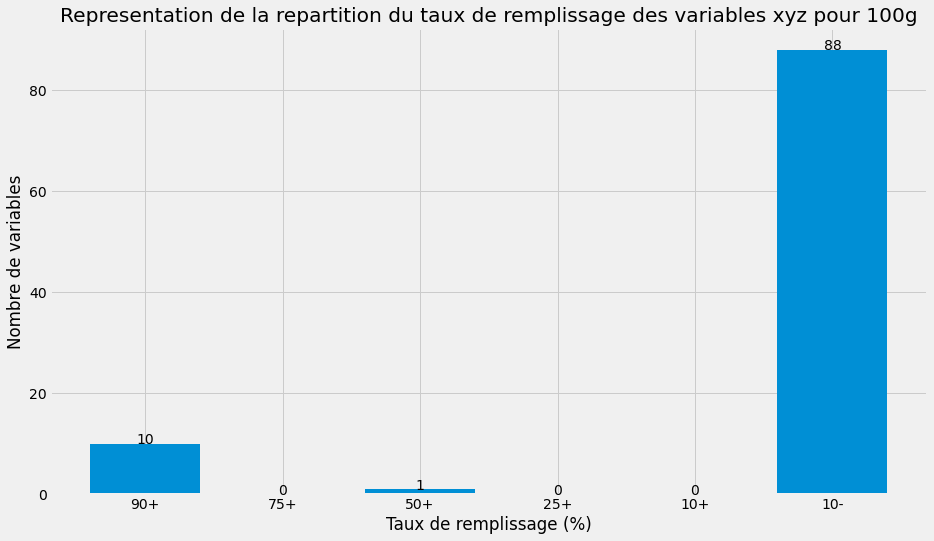

In [15]:
hundred_g_dict = {
    "90+": [],
    "75+": [],
    "50+": [],
    "25+": [],
    "10+": [],
    "10-": []
}
for col in hundred_g_list:
    percent_values = df_off[col].notna().sum() / len(df_off) * 100
    if percent_values > 90:
        hundred_g_dict["90+"].append(col)
    elif percent_values > 75:
        hundred_g_dict["75+"].append(col)
    elif percent_values > 50:
        hundred_g_dict["50+"].append(col)
    elif percent_values > 25:
        hundred_g_dict["25+"].append(col)
    elif percent_values < 10:
        hundred_g_dict["10-"].append(col)

plot_dict = {}
for key in hundred_g_dict.keys():
    plot_dict[key] = len(hundred_g_dict[key])

labels_x = list(plot_dict.keys())
amount_y = list(plot_dict.values())

plt.figure(figsize=(14, 8))

def addtext(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha='center')

addtext(labels_x, amount_y)

plt.bar(labels_x, amount_y, width=0.8)

plt.ylabel("Nombre de variables")
plt.xlabel("Taux de remplissage (%)")

title_r1 = "Representation de la repartition du taux de remplissage des variables xyz pour 100g"
plt.title(title_r1)
plt.show()


<h4>10 variables (en comptant les variables "nutrition_score_100g" fr et uk) dépassent les 90% de remplissage.</h4>

Elles seront intégrées au dataset de sortie et peuvent servir d'info supplementaire, soit pour l'application soit pour l'étude

In [16]:
print(hundred_g_dict["90+"])


['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']


In [17]:
dropped_hundred = ['nutrition-score-fr_100g', 'nutrition-score-uk_100g']
selected_hundred = [col for col in hundred_g_dict["90+"] if col not in dropped_hundred]


<h3>Seulement 10 variables ont un taux de remplissage superieur a 90%</h3>

- Les variables plus haut seront donc selectionnées, à l'exception de 'nutrition-score-fr_100g', 'nutrition-score-uk_100g' : le nutriscore est deja present dans les variables selectionnees.
- Il s'agit de s'assurer que les valeurs ne sont pas aberrantes (+100% , - 0%), dans le cas des satured-fats, s'assurer que la valeur est inferieur a fat (fat_100g = satured_fat_100g + others)

In [18]:
%%time

aberrant_indexes = []

# Using bare xyz_100g results in returning false positives since energy for 100g > 100 in many cases, and energy
# not expressed in grams

# A faster method is likely possible

comparison_cols = [col for col in selected_hundred if not col.startswith("energy")]

for index, series in df_off.iterrows():
    if is_aberration(series, comparison_cols):
        aberrant_indexes.append(index)
    if float(series["saturated-fat_100g"]) > float(series["fat_100g"]):
        aberrant_indexes.append(index)

print(len(aberrant_indexes), " ligne(s) érronées")

df_off = df_off.drop(index=aberrant_indexes)


68  ligne(s) érronées
CPU times: total: 3.34 s
Wall time: 3.34 s


Choix des variables "labels", "categories":

In [19]:
print("labels:", df_off["labels"].notna().sum())
print("labels_tags:", df_off["labels_tags"].notna().sum())
print("labels_fr:", df_off["labels_fr"].notna().sum(), "\n")

print("categories:", df_off["categories"].notna().sum())
print("categories_tags:", df_off["categories_tags"].notna().sum())
print("categories_fr:", df_off["categories_fr"].notna().sum())


labels: 21540
labels_tags: 21574
labels_fr: 21574 

categories: 39241
categories_tags: 39241
categories_fr: 39241


On preferera l'utilisation noms en francais pour les labels : doc = https://fr.openfoodfacts.org/labels , labels seul semble avoir moins de donnees que les deux autres

<h1>Création d'un score éco/bio</h1>

Les labels pourront fournir des infos sur le caractere ecologique, bio etc. des produits, en combinant cela aux informations relatives à l'utilisation de l'huile de palme, on peut établir un score écologie a chaque produit.
Le site reference plus de 1500 labels. 
On se limitera a certains : (https://fr.openfoodfacts.org/labels) (les plus nombreux denottant du bio ou ecologique)
- Bio
- Bio européen
- AB Agriculture Biologique
- Point vert (?)
- FR-BIO-01
- Commerce équitable (?)
- Agriculture durable (?)

On peut separer ces labels en deux : écologie et bio.

On attribuera ces valeurs a un dictionnaire et une fonction s'assurera de la notation

Il convient de definir ce score écologique - 
Proposition : 
- Neutre (0)
- Négatif (-1)
- Positif (1)
- Non évalué (np.nan)


In [20]:
bio_list = ["bio", "bioeuropeen", "abagriculturebiologique", "fr-bio-01"]


In [21]:
final_selection = list(remaining + selected_hundred)
# final_selection


In [22]:
df_export = df_off[final_selection].reset_index(drop=True)


In [23]:
%%time
df_export["organic"] = np.nan
df_export["palm_oil"] = np.nan
for index, series in df_export.iterrows():
    result_dict = get_green_rating(series=series, bio_list=bio_list)
    df_export.at[index, "organic"] = result_dict["org"]
    df_export.at[index, "palm_oil"] = result_dict["palm_oil"]


CPU times: total: 2.83 s
Wall time: 2.86 s


On peut maintenant alleger le DataFrame en enlevant les colonnes servant au calcul du green_rating :

In [24]:
green_rating_cols = ["labels", "ingredients_from_palm_oil_n", "ingredients_that_may_be_from_palm_oil_n"]
final_selection = final_selection + ["organic", "palm_oil"]
final_selection = [col for col in final_selection if col not in green_rating_cols]


In [25]:
df_export[final_selection].to_csv("data/cleaned_data.csv")


<h3>Export en tant que .csv<h3>